In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from google.colab import widgets
import copy as cp

# Практическое задание VI.9.2 пункт d)

Будем решать практическое упражнение **VI.9.2 пункт d)**

## Задача

Таблично задана функция $f(x)$

|      $x$      |      $f(x)$      |
| :-----------: | :--------------: |
|  $x_1 = 0.$   |        $1$       |
|  $x_2 = 1.$   |       $0.5$      |
|  $x_3 = 2.$   |       $0.3$      |
|  $x_4 = 5.$   |       $0.2$      |
|  $x_5 = 7.$   |       $0.1$      |

Необходимо найти $f'(2.)$

* с помощью интерполяции
* методом неопределенных коэффициентов

## Начальные данные

Попытался выполнить выбранный вариант, получил неправильный ответ. В другом варианте получил правильный ответ. По этой причине сделаю все варианты и посмотрю, проблема во мне или в ответах.

In [ ]:
variants = {
            "a": {"points": [(0, 0.5), (1, 0.3), (3, 0.3), (4, 0.2), (5, 0.1)], 
                  "investigated_point": 5,
                  "correct_answer": -0.085},
            "b": {"points": [(0, 5), (0.1, 2.5), (0.2, 3), (0.3, -2.5), (0.4, -0.2)], 
                  "investigated_point": 0.3,
                  "correct_answer": -58},
            "c": {"points": [(0, 4), (1, 2.5), (2, 1), (3, -1), (4, -2)], 
                  "investigated_point": 3,
                  "correct_answer": -1.9},
            "d": {"points": [(0, 1), (1, 0.5), (2, 0.3), (5, 0.2), (7, 0.1)], 
                  "investigated_point": 2,
                  "correct_answer": -2.18},
            "e": {"points": [(0, -1), (2, 0), (3, 2), (5, 3), (7, 5)], 
                  "investigated_point": 3,
                  "correct_answer": 1.6}
}

## Написание класса для работы

Напишем класс для табличной функции, которая будет хранить все точки и иметь все необходимые методы для интерполяции и работы с интерполированной функцией.

In [ ]:
import bisect

class TableFunction:

  def __init__(self): 
    self.X = []
    self.Y = []
    self.interpolated_function = None
    self.interpolation_type = None
    self.interpolation_point = None
    self.B = []
    self.splines_a = []
    self.splines_b = []
    self.splines_c = []
    self.splines_d = []


  def addPoints(self, *points):
    if len(points) > 0 and type(points[0]) == list:
      points = points[0]
    for point in points:
      self.X.append(point[0])
      self.Y.append(point[1])
    self.calculateB()


  def calculateB(self):
    self.B.append(self.Y)
    while len(self.B[-1]) != 1:
      b_column = []
      for i in range(len(self.B[-1]) - 1):
        b_column.append((self.B[-1][i + 1] - self.B[-1][i]) / (self.X[i + (len(self.X) - (len(self.B[-1]) - 1))] - self.X[i]))
      self.B.append(b_column)


  def interpolateNewton(self, investigated_point = 0):
    self.interpolation_point = investigated_point

    if investigated_point <= (max(self.X) - min(self.X)) / 2:   # FIX X and Y massives can be shuffled
      b_mass = [b_column[0] for b_column in self.B]
      x_fixed_mass = [self.X[0:i] for i in range(len(self.X))]
    else:
      b_mass = [b_column[-1] for b_column in self.B]
      x_fixed_mass = [self.X[i:len(self.X)] for i in range(len(self.X), 0, -1)]

    def function(x):
      y = 0
      for b, x_fixed in zip(b_mass, x_fixed_mass):
        factor = 1
        for x0 in x_fixed:
          factor *= (x - x0)
        
        y += b * factor

      return y

    self.interpolated_function = function
    self.interpolation_type = "Newton interpolation"

    return function


  @staticmethod
  def solveTdSystem(A, C):
    y = []
    alpha = []
    beta = []
    x = [0 for _ in range(10)]
    for i in range(0, len(C)):
      y.append(A[i, i] + ((A[i, i-1] * alpha[i-1]) if i > 0 else 0))
      alpha.append((-A[i, i+1] / y[i]) if i < (len(C) - 1) else 0)
      beta.append((C[i] - ((A[i, i-1] * beta[i-1]) if i > 0 else 0)) / y[i])
    
    for i in range(len(C) - 1, -1, -1):
      x[i] = beta[i] + ((alpha[i] * x[i+1]) if i < (len(C) - 1) else 0)

    return x


  def calculateSplinesСoefficients(self):
    h = np.diff(self.X)

    self.splines_a = cp.deepcopy(self.Y)

    td_matrix = np.zeros((len(self.X), len(self.X)))

    td_matrix[0, 0] = 1
    td_matrix[-1, -1] = 1

    for i in range(1, len(self.X) - 1):
      td_matrix[i, i-1] = h[i-1]
      td_matrix[i, i] = 2 * (h[i-1] + h[i])
      td_matrix[i, i+1] = h[i]

    col = np.zeros(len(self.X))

    for i in range(1, len(self.X) - 1):
      col[i] = 3 * (self.Y[i + 1] - self.Y[i]) / h[i] - 3 * (self.Y[i] - self.Y[i - 1]) / h[i-1]

    self.splines_c = self.solveTdSystem(td_matrix, col)

    for i in range(len(self.X) - 1):
      self.splines_d.append((self.splines_c[i + 1] - self.splines_c[i]) / (3 * h[i-1]))
      self.splines_b.append((self.Y[i + 1] - self.Y[i]) / h[i-1] - (self.splines_c[i + 1] + 2 * self.splines_c[i]) * h[i-1] / 3)


  def interpolateSplines(self, investigated_point = 0):
    self.interpolation_point = investigated_point

    self.calculateSplinesСoefficients()

    a = cp.deepcopy(self.splines_a)
    b = cp.deepcopy(self.splines_b)
    c = cp.deepcopy(self.splines_c)
    d = cp.deepcopy(self.splines_d)

    def function(x):
      i = bisect.bisect(self.X, x) - 1
      if i >= len(b):
        i = len(b) - 1

      dx = x - self.X[i]

      return a[i] + b[i] * dx + c[i] * dx**2 + d[i] * dx**3

    self.interpolated_function = function
    self.interpolation_type = "Splines interpolation"

    return function


  def findDerivative(self, investigated_point, h = 0.0001):
    if self.interpolated_function == None or self.interpolation_point != investigated_point:
      self.interpolateNewton(investigated_point)
    return (self.interpolated_function(investigated_point + h) - 
            self.interpolated_function(investigated_point - h)) / (2 * h)


  def drawFunction(self, beginning = None, end = None):
    if self.interpolated_function == None:
      self.interpolateNewton(0)

    x_band = np.linspace(min(self.X) if beginning == None else beginning, 
                         max(self.X) if end == None else end, 1000)
    y_band = [self.interpolated_function(x) for x in x_band]

    plt.figure(figsize=[12,7])
    plt.grid()
    plt.stem(self.X, self.Y, use_line_collection = True, label = "Table function")
    plt.plot(x_band, y_band, label = "Interpolated function", color = "orange")

    plt.legend()
    plt.title(self.interpolation_type)

## Поиск производных

Вычислим производную в заданной точке с помощью интерполяции, а так же построим для наглядности графики интерполированных функций.

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Newton:  Derivative in point 5 is -0.030000, expected -0.085


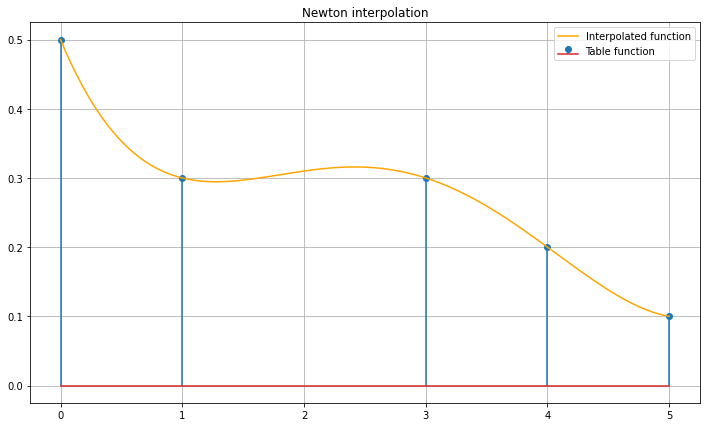

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Newton:  Derivative in point 0.3 is -57.999958, expected -58


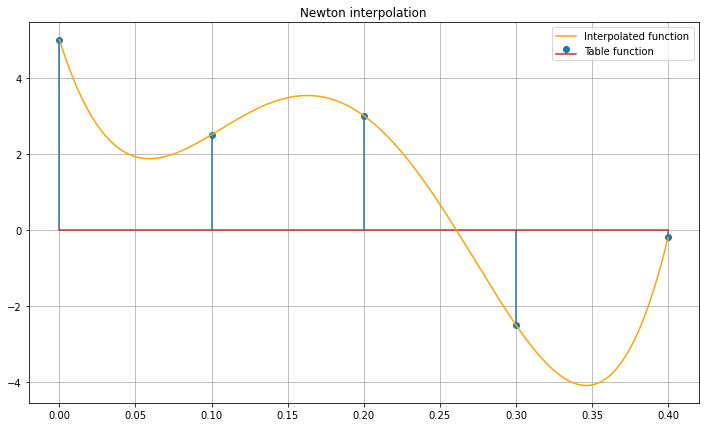

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Newton:  Derivative in point 3 is -1.916667, expected -1.9


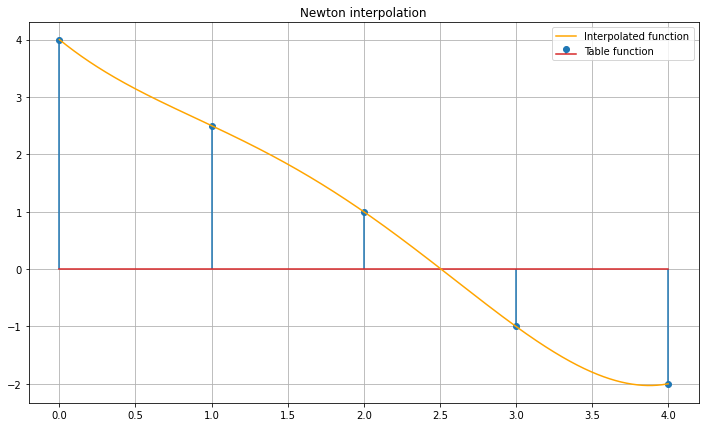

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Newton:  Derivative in point 2 is -0.105476, expected -2.18


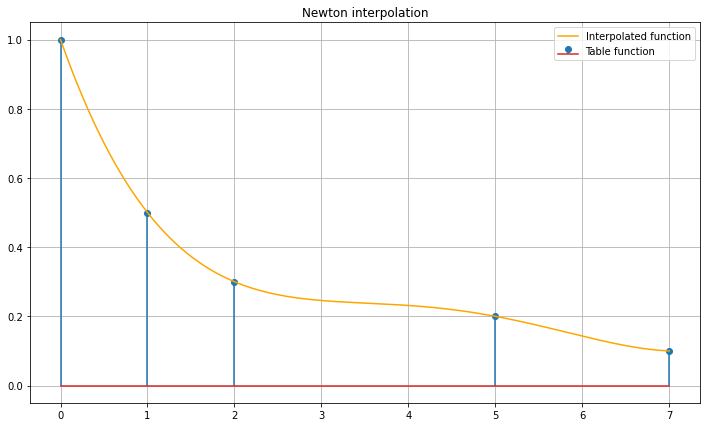

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Newton:  Derivative in point 3 is 1.621429, expected 1.6


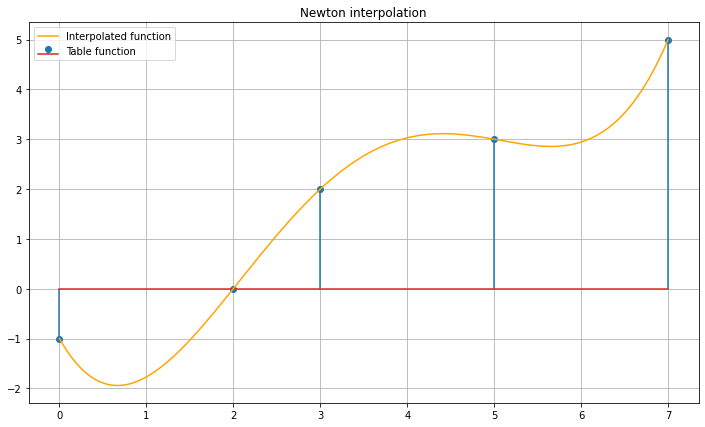

<IPython.core.display.Javascript object>

In [ ]:
tabs = list(variants.keys())
tb = widgets.TabBar(tabs)

for tab in tabs:
  with tb.output_to(tab):
    function = TableFunction()
    function.addPoints(variants[tab]["points"])

    function.interpolateNewton(variants[tab]["investigated_point"])
    function.drawFunction()
    der = function.findDerivative(variants[tab]["investigated_point"])
    print(f"""Newton:  Derivative in point {variants[tab]["investigated_point"]} is {der:.06f}, expected {variants[tab]["correct_answer"]}""")


# Практическое задание **IV.9.32**

Так же выполним задание для отличников.

| Год  | Население   |
| :--: | :---------: |
| 1910 | 92 228 496  |
| 1920 | 106 021 537 |
| 1930 | 123 202 624 |
| 1940 | 132 164 569 |
| 1950 | 151 325 798 |
| 1960 | 179 323 175 |
| 1970 | 203 211 926 |
| 1980 | 226 545 805 |
| 1990 | 248 709 873 |
| 2000 | 281 421 906 |

По этим данным построим интерполянт в форме Ньютона. Вычислим экстраполированное значение численности населения в 2010 году.

Реальное значение - 308 745 538 человек

Занесем табличные значения в массив и добавим в новую табличную функцию.

In [ ]:
population = [
              (1910, 92228496),
              (1920, 106021537),
              (1930, 123202624),
              (1940, 132164569),
              (1950, 151325798),
              (1960, 179323175),
              (1970, 203211926),
              (1980, 226545805),
              (1990, 248709873),
              (2000, 281421906)
]

population_table = TableFunction()
population_table.addPoints(population)

## Интерполяция по Ньютону

Теперь проведем интерполяцию, выведем график и подсчитаем значение для 2010 года.

Newton interpolation: 827906509


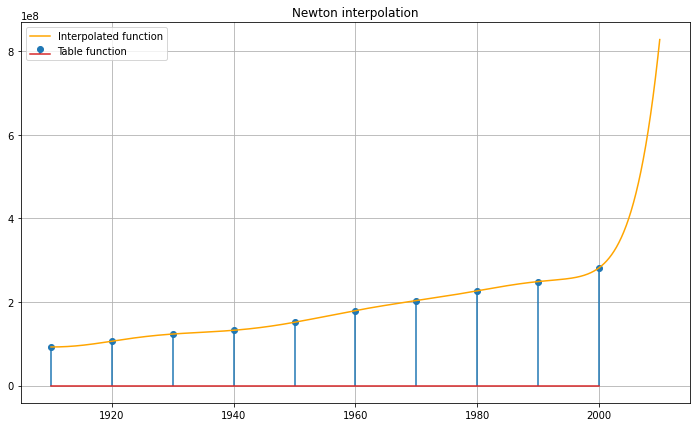

In [ ]:
interpolated = population_table.interpolateNewton(investigated_point = 2010)
population_table.drawFunction(end = 2010)

print(f"Newton interpolation: {interpolated(2010):.0f}")

Так, с помощью интерполянта Ньютона мы получили значение 827 906 509 человек для 2010 года. Полученное значение заметно отличается от реального значения. Очевидно, что интерполяция Ньютона не очень подходит для нашей задачи.

## Интерполяция сплайнами

Теперь проведем интерполяцию сплайнами для нашей табличной функции.

Splines interpolation: 314133939


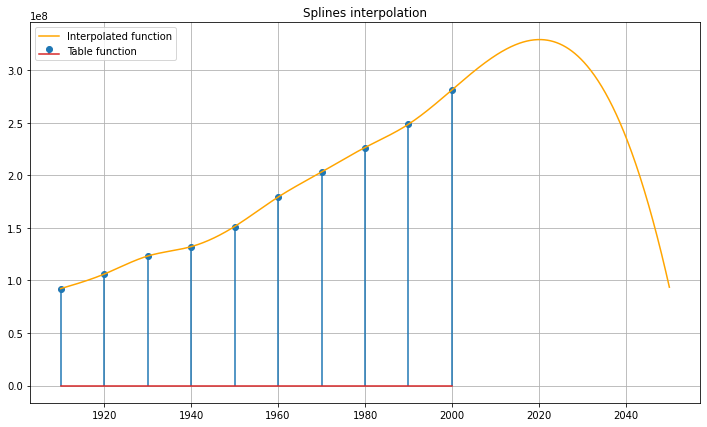

In [ ]:
#raise Exception("This part is not implemented")

interpolated = population_table.interpolateSplines(investigated_point = 2010)
population_table.drawFunction(end = 2050)

print(f"Splines interpolation: {interpolated(2010):.0f}")

Таким образом с помощью интерполяции сплайнами мы получили значение для 2010 года: 314 133 939 человек

## Сравнение результатов

Как можно заметить, результат, полученный с помощью сплайнов, оказался гораздо точнее, полученного по Ньютону.